In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## load and pre-process data

In [2]:
# load data from csv
df = pd.read_csv('../Data/Smarket.csv')

# convert string to numeric for logistic regression
df.loc[df.Direction == 'Up', 'Direction2'] = 1
df.loc[df.Direction == 'Down', 'Direction2'] = 0

df.head(10)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1.0
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1.0
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0.0
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1.0
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1.0
5,6,2001,0.213,0.614,-0.623,1.032,0.959,1.3491,1.392,Up,1.0
6,7,2001,1.392,0.213,0.614,-0.623,1.032,1.4450,-0.403,Down,0.0
7,8,2001,-0.403,1.392,0.213,0.614,-0.623,1.4078,0.027,Up,1.0
8,9,2001,0.027,-0.403,1.392,0.213,0.614,1.1640,1.303,Up,1.0
9,10,2001,1.303,0.027,-0.403,1.392,0.213,1.2326,0.287,Up,1.0


## 5-folds cross validation

In [3]:
for year in [2001, 2002, 2003, 2004, 2005]:
    df_train = df[df.Year != year]  # validation set
    df_test = df[df.Year == year]  # training set

    X_train = sm.add_constant(df_train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
    y = df_train['Direction2']
    est = smf.Logit(y, X_train).fit()
    est.summary2().tables[1]

    X_test = sm.add_constant(df_test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
    pred_y = est.predict(X_test)

    df_test['pred_Direction2'] = pred_y
    df_test['pred_Direction'] = 'Down'
    df_test.loc[df_test.pred_Direction2 > .5, 'pred_Direction'] = 'Up'

    df_ = pd.DataFrame({'True': df_test.Direction,
                        'Prediction': df_test.pred_Direction})
    
    print('--------------------- validation == ' + str(year) + ' ---------------------')
    print(df_.groupby(['Prediction','True']).size().unstack('True'))

Optimization terminated successfully.
         Current function value: 0.689210
         Iterations 4
--------------------- validation == 2001 ---------------------
True        Down  Up
Prediction          
Down          37  37
Up            88  80
Optimization terminated successfully.
         Current function value: 0.689089
         Iterations 4


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

--------------------- validation == 2002 ---------------------
True        Down  Up
Prediction          
Down          21  15
Up           119  97
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 4
--------------------- validation == 2003 ---------------------
True        Down  Up
Prediction          
Down          45  71
Up            69  67
Optimization terminated successfully.
         Current function value: 0.691252
         Iterations 4
--------------------- validation == 2004 ---------------------
True        Down  Up
Prediction          
Down          48  58
Up            64  82
Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
--------------------- validation == 2005 ---------------------
True        Down  Up
Prediction          
Down          77  97
Up            34  44


## PCA

In [4]:
X = df.ix[:, 2:8]  # get useful variables only

pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(X.head())
print(scale(X)[0:5,:])
print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

    Lag1   Lag2   Lag3   Lag4   Lag5  Volume
0  0.381 -0.192 -2.624 -1.055  5.010  1.1913
1  0.959  0.381 -0.192 -2.624 -1.055  1.2965
2  1.032  0.959  0.381 -0.192 -2.624  1.4112
3 -0.623  1.032  0.959  0.381 -0.192  1.2760
4  0.614 -0.623  1.032  0.959  0.381  1.2057
[[ 0.3320575  -0.17249056 -2.30680609 -0.92824314  4.36267914 -0.79676487]
 [ 0.8409301   0.33198828 -0.17018796 -2.30659244 -0.92460799 -0.50471538]
 [ 0.90519947  0.84086919  0.33321755 -0.1701071  -2.29241566 -0.1862926 ]
 [-0.55186652  0.90513962  0.84101577  0.33326711 -0.17227019 -0.56162617]
 [ 0.53719126 -0.5519502   0.90514946  0.84103378  0.32725422 -0.75678852]]
(6, 6)


,0,1,2,3,4,5
0,0.486968,-0.138047,0.152076,-0.177786,-0.828174,-0.056556
1,-0.402710,0.460867,0.190891,0.525937,-0.416889,0.372264
2,-0.183139,-0.492161,-0.691517,0.066810,-0.197703,0.449991
3,-0.283882,-0.433932,0.631923,-0.341495,0.063376,0.459513
4,-0.063266,0.571114,-0.244079,-0.715494,-0.044815,0.310342


In [5]:
# transformed data (Z)
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(1250, 6)


,0,1,2,3,4,5
0,0.087650,3.817617,-0.084670,-3.301504,-0.247235,-0.663855
1,0.669669,0.538570,-0.952118,1.340617,-1.061683,-1.645261
2,0.105064,-1.157126,0.509023,1.956714,-1.131622,-0.487761
3,-1.261123,-0.224732,-0.272512,0.503648,-0.231037,0.514852
4,-0.467068,-1.034461,-0.241714,-1.030142,-0.588630,0.212872


In [6]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 18.11,  35.29,  52.43,  69.05,  85.2 ,  99.99])

## Random forests

In [7]:
# divide data into train and test
df_train = df[df.Year < 2005]
df_test = df[df.Year >= 2005]

X_train = df_train.ix[:, 2:8]
X_test = df_test.ix[:, 2:8]
y_train = df_train.ix[:, 10]
y_test = df_test.ix[:, 10]

In [8]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=6, random_state=1)
regr1.fit(X_train, y_train)
pred = regr1.predict(X_test)

In [9]:
result = pd.DataFrame(y_test)
result['pred_Direction2'] = pred

result.loc[result.pred_Direction2 > .5, 'pred_Direction2'] = 1
result.loc[result.pred_Direction2 <= .5, 'pred_Direction2'] = 0

result['correct'] = 0
result.loc[result.pred_Direction2 == result.Direction2, 'correct'] = 1

print('accuracy')
print(result['correct'].sum() / float(result.shape[0]))

accuracy
0.468253968254


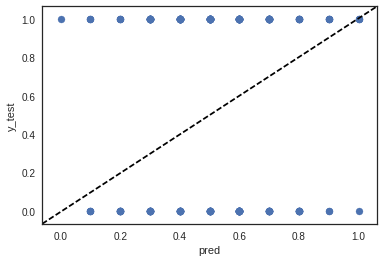

In [10]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

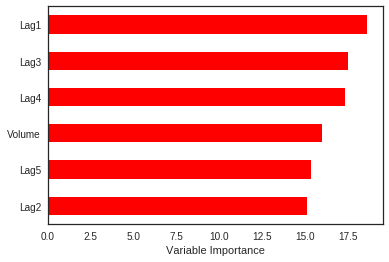

In [11]:
Importance = pd.DataFrame({'Importance':regr1.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## Boosting

In [12]:
# divide data into train and test
df_train = df[df.Year < 2005]
df_test = df[df.Year >= 2005]

regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

In [13]:
result = pd.DataFrame(y_test)
result['pred_Direction2'] = pred

result.loc[result.pred_Direction2 > .5, 'pred_Direction2'] = 1
result.loc[result.pred_Direction2 <= .5, 'pred_Direction2'] = 0

result['correct'] = 0
result.loc[result.pred_Direction2 == result.Direction2, 'correct'] = 1

print('accuracy')
print(result['correct'].sum() / float(result.shape[0]))

accuracy
0.5


Lag3       8.604152
Lag5      12.913437
Lag4      14.974953
Lag1      17.874380
Volume    21.555041
Lag2      24.078036
dtype: float64


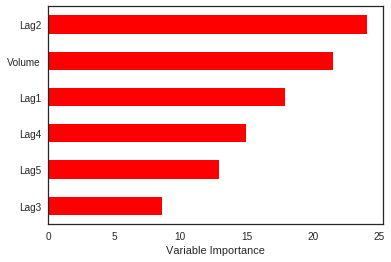

In [14]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None